In [1]:
import sys
sys.path.insert(0,'/Users/tiagorodrigues/Documents/GitHub/NeuroKit')

import os
import wfdb
from wfdb.processing import compare_annotations
import neurokit2 as nk
import h5py
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import pickle

# Detectors comparison: TP, FN, FP ->  Sensitivity (Se) and Positive Predictive Value (PPV)
Comparison of precision of the different R-peak detectors

Detectors:
- Pan and Tompkins
- Christov
- Gamboa
- Elgendi
- Engzee modified
- Kalidas
- ASI (rodrigues2020)

## 1. Detection window from the R-peak:  ( 25 samples, 100 ms)

In [12]:
directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana/Annotated"
rpeaks_total = 0
files = [i for i in os.listdir(directory)]
for file in files:
    
    filename = os.path.join(directory, file)
    f = h5py.File(filename,'r')

    timestamps = f['events/ECG/raw/ecg/N/timeStamps'][:,1]
    rpeaks_total = rpeaks_total + len(timestamps)    
    f.close()    
print( "Total de R-peaks:",rpeaks_total)

Total de R-peaks: 39817


In [13]:
# Go to directory with annotated files
# Run through all the files
directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana/Annotated"

data = {'Record':[],
        'TP':[],
        'FN':[],
        'FP':[],
        }
detectors_total = pd.DataFrame (data)

fs = 250
time_window = 0.1 #0.1 sec (100ms)
samples_window = np.round(fs * time_window) 
samples_window


files = [i for i in os.listdir(directory)]
for file in files:
    
    filename = os.path.join(directory, file)
    f = h5py.File(filename,'r')

    # Get ECG and timestamps from hdf5
    # ecg
    ecg = f['signals/ECG/raw/ecg'][:]
    
    # reverse polarity for engzee to work (ECG has inverted polarities)
    ecg = ecg * (-1)

    # R-peaks positions annotated (1st collumn)
    timestamps = f['events/ECG/raw/ecg/N/timeStamps'][:,1]
    timestamps = np.sort(timestamps)
        
    methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
    #methods = ['rodrigues2020']
    for this_method in methods: 
        
        # Get annotations from the detector
        # Pth = 5 and N = 5, only used for rodrigues2020
        detector_peaks = nk.ecg_findpeaks(ecg, sampling_rate = fs, method = this_method, show = False)
        timestamps_detector = np.asarray(detector_peaks['ECG_R_Peaks'])

        # Get physionet comparator
        comparator_object = compare_annotations(timestamps, timestamps_detector, samples_window, signal=None)

        # Get FP, FN and FP
        TP = comparator_object.tp
        FN = comparator_object.fn
        FP = comparator_object.fp

        detectors_total = detectors_total.append({'Record':file +'-'+ this_method, 'TP':TP, 'FN': FN,'FP':FP},ignore_index=True)
        f.close()
    print(file + ": check")
            
os.system('say "your program has finished"')

20200413-JM-FWv2-Annotated.hdf5: check
20200505-TR-Belt-Annotated.hdf5: check
20200421-JT-FWv2-Annotated.hdf5: check
20200405-TR-FWv2-Annotated.hdf5: check
20200508-SS-Belt-Annotated.hdf5: check


0

In [28]:
# Save the results
#detectors_total.to_pickle("Se_P_100ms.pkl")

# Read the results
detectors_total = pd.read_pickle('Se_P_100ms.pkl')

## Se and PPV for the five recordings using all methods, sample window of 25 samples (100ms):

In [29]:
# Dataframe with TP, FP and FN
detectors_total;

# Compute Sensitivity and positive predictivity
detectors_total_se_p = [detectors_total['Record'], detectors_total['TP']/(detectors_total['TP'] + detectors_total['FN']), detectors_total['TP']/(detectors_total['TP'] + detectors_total['FP'])]
detectors_total_se_p = pd.DataFrame({'Record':detectors_total_se_p[0],'Se':detectors_total_se_p[1], 'PPV':detectors_total_se_p[2]})
detectors_total_se_p

,Record,Se,PPV
0,20200413-JM-FWv2-Annotated.hdf5-pantompkins1985,0.995964,0.960311
1,20200413-JM-FWv2-Annotated.hdf5-christov2004,0.991122,0.926393
2,20200413-JM-FWv2-Annotated.hdf5-gamboa2008,0.669203,0.584550
3,20200413-JM-FWv2-Annotated.hdf5-elgendi2010,0.578001,0.666445
4,20200413-JM-FWv2-Annotated.hdf5-engzeemod2012,0.989508,0.966768
5,20200413-JM-FWv2-Annotated.hdf5-kalidas2017,0.999654,0.965371
6,20200413-JM-FWv2-Annotated.hdf5-rodrigues2020,0.999308,0.962893
7,20200505-TR-Belt-Annotated.hdf5-pantompkins1985,0.984856,0.998185
8,20200505-TR-Belt-Annotated.hdf5-christov2004,0.994952,0.852518
9,20200505-TR-Belt-Annotated.hdf5-gamboa2008,0.627097,0.543927


## Compute basic statistics (mean and std) across the 5 recordings, for each detector

,Method,Se_mean,Se_std,PPV_mean,PPV_std
0,PanTompkins,99.340178,0.430288,99.044782,1.508501
1,Chistov,99.070730,0.619265,93.952159,5.203194
2,Gamboa,63.989427,9.216020,56.232141,12.026763
3,Elgendi,72.888396,19.165413,81.829653,13.218294
4,Engzee,96.160588,5.723443,99.252361,1.292579
5,Kalidas,99.905188,0.115855,99.278362,1.370784
6,Rodrigues,99.770966,0.325244,99.183174,1.447299


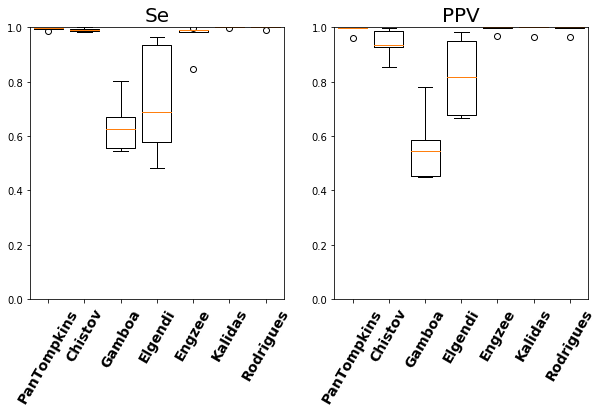

In [22]:
methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
name_method = ['PanTompkins','Chistov','Gamboa','Elgendi','Engzee','Kalidas','Rodrigues']


data = {'Method':[],
        'Se_mean':[],
        'Se_std':[],
        'PPV_mean':[],
        'PPV_std':[],
        }
se_p = pd.DataFrame(data)


fig = plt.figure(1, figsize=(10, 5))
ax1 = fig.add_subplot(121) 
plt.title('Se',fontsize = 20)


ax2 = fig.add_subplot(122)   
plt.title('PPV',fontsize = 20)


i = 0
for method in methods:
    thismethod_data = detectors_total_se_p[detectors_total_se_p['Record'].str.contains(methods[i])]
    
    se_mean = np.mean(100 * thismethod_data['Se'])
    se_std = np.std(100 * thismethod_data['Se'])
    p_mean = np.mean(100 * thismethod_data['PPV'])
    p_std = np.std(100 * thismethod_data['PPV'])
    
    
    ax1.boxplot(thismethod_data['Se'], positions = [i], widths = 0.8)
    ax2.boxplot(thismethod_data['PPV'], positions = [i],widths = 0.8)
    ax1.set_ylim([0, 1])
    ax2.set_ylim([0, 1])
    
    ax1.set_xticklabels(name_method,rotation=60, fontsize = 14, fontweight='bold')
    ax2.set_xticklabels(name_method,rotation=60, fontsize = 14, fontweight='bold')
    
    
    se_p = se_p.append({'Method':name_method[i], 
                        'Se_mean':se_mean,
                        'Se_std': se_std,
                        'PPV_mean':p_mean,
                        'PPV_std':p_std},
                        ignore_index=True)
    i=i+1
se_p

# Detection window: 5 samples

In [30]:
# Go to directory with annotated files
# Run through all the files
directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana/Annotated"

data = {'Record':[],
        'TP':[],
        'FN':[],
        'FP':[],
        }
detectors_total = pd.DataFrame (data)

fs = 250
time_window = 0.02 # 0.02 sec (20 ms)
samples_window = np.round(fs * time_window) 
samples_window


files = [i for i in os.listdir(directory)]
for file in files:
    
    filename = os.path.join(directory, file)
    f = h5py.File(filename,'r')

    # Get ECG and timestamps from hdf5
    # ecg
    ecg = f['signals/ECG/raw/ecg'][:]
    
    # reverse polarity for engzee to work (ECG has inverted polarities)
    ecg = ecg * (-1)

    # R-peaks positions annotated (1st collumn)
    timestamps = f['events/ECG/raw/ecg/N/timeStamps'][:,1]
    timestamps = np.sort(timestamps)
        
    methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
    #methods = ['rodrigues2020']
    for this_method in methods: 
        
        # Get annotations from the detector
        # Pth = 5 and N = 5, only used for rodrigues2020
        detector_peaks = nk.ecg_findpeaks(ecg, sampling_rate = fs, method = this_method, show = False)
        timestamps_detector = np.asarray(detector_peaks['ECG_R_Peaks'])

        # Get physionet comparator
        comparator_object = compare_annotations(timestamps, timestamps_detector, samples_window, signal=None)

        # Get FP, FN and FP
        TP = comparator_object.tp
        FN = comparator_object.fn
        FP = comparator_object.fp

        detectors_total = detectors_total.append({'Record':file +'-'+ this_method, 'TP':TP, 'FN': FN,'FP':FP},ignore_index=True)
        f.close()  
    print(file + ": check")
          
os.system('say "your program has finished"')

20200413-JM-FWv2-Annotated.hdf5: check
20200505-TR-Belt-Annotated.hdf5: check
20200421-JT-FWv2-Annotated.hdf5: check
20200405-TR-FWv2-Annotated.hdf5: check
20200508-SS-Belt-Annotated.hdf5: check


0

In [31]:
# Save the results
detectors_total.to_pickle("Se_P_20ms.pkl")

# Read the results
detectors_total = pd.read_pickle('Se_P_20ms.pkl')

## Results for 5 recordings using all methods, sample window of 5 samples (20 ms):

,Method,Se_mean,Se_std,PPV_mean,PPV_std
0,PanTompkins,32.235962,9.431860,32.048589,9.198137
1,Chistov,84.962241,10.934114,80.536672,11.445903
2,Gamboa,56.533153,10.873585,49.834821,13.121878
3,Elgendi,70.295219,20.503875,78.716715,15.108234
4,Engzee,95.713684,5.543361,98.808945,1.750928
5,Kalidas,99.858970,0.125598,99.232500,1.375592
6,Rodrigues,99.644183,0.346876,99.058447,1.535308


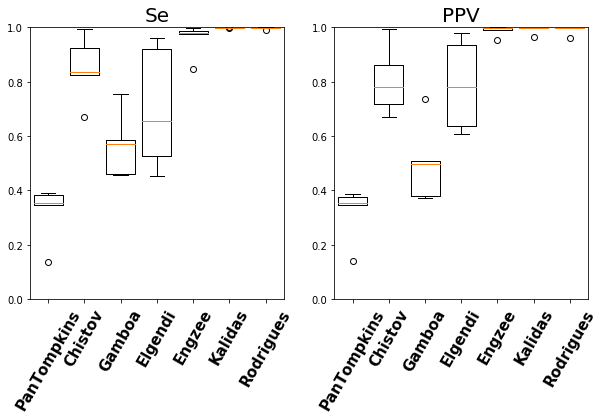

In [32]:
# Dataframe with TP, FP and FN
detectors_total;

# Compute Sensitivity and positive predictivity
detectors_total_se_p = [detectors_total['Record'], detectors_total['TP']/(detectors_total['TP'] + detectors_total['FN']), detectors_total['TP']/(detectors_total['TP'] + detectors_total['FP'])]
detectors_total_se_p = pd.DataFrame({'Record':detectors_total_se_p[0],'Se':detectors_total_se_p[1], 'PPV':detectors_total_se_p[2]})
detectors_total_se_p


# Median and std of each recording
methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
name_method = ['PanTompkins','Chistov','Gamboa','Elgendi','Engzee','Kalidas','Rodrigues']


data = {'Method':[],
        'Se_mean':[],
        'Se_std':[],
        'PPV_mean':[],
        'PPV_std':[],
        }
se_p = pd.DataFrame (data)


fig = plt.figure(1, figsize=(10, 5))
ax1 = fig.add_subplot(121) 
plt.title('Se',fontsize = 20)


ax2 = fig.add_subplot(122)   
plt.title('PPV',fontsize = 20)


i = 0
for method in methods:
    thismethod_data = detectors_total_se_p[detectors_total_se_p['Record'].str.contains(methods[i])]
    
    se_mean = np.mean(100 * thismethod_data['Se'])
    se_std = np.std(100 * thismethod_data['Se'])
    p_mean = np.mean(100 * thismethod_data['PPV'])
    p_std = np.std(100 *thismethod_data['PPV'])
    
    
    ax1.boxplot(thismethod_data['Se'], positions = [i], widths = 0.8)
    ax2.boxplot(thismethod_data['PPV'], positions = [i],widths = 0.8)
    
    ax1.set_xticklabels(name_method,rotation=60, fontsize = 15, fontweight='bold')
    ax2.set_xticklabels(name_method,rotation=60, fontsize = 15, fontweight='bold')
    
    # Set limits
    ax1.set_ylim([0, 1])
    ax2.set_ylim([0, 1])
    
    se_p = se_p.append({'Method':name_method[i], 
                        'Se_mean':se_mean,
                        'Se_std': se_std,
                        'PPV_mean':p_mean,
                        'PPV_std':p_std},
                       ignore_index=True)
    i=i+1
se_p


# Optimization of N and Pth

In [82]:
def _ecg_findpeaks_rodrigues(N, Pth, signal, sampling_rate=1000):
    """Segmenter by Tiago Rodrigues, inspired by on Gutierrez-Rivas (2015) and Sadhukhan (2012).

    References
    ----------
    - Gutiérrez-Rivas, R., García, J. J., Marnane, W. P., & Hernández, A. (2015). Novel real-time
      low-complexity QRS complex detector based on adaptive thresholding. IEEE Sensors Journal,
      15(10), 6036-6043.

    - Sadhukhan, D., & Mitra, M. (2012). R-peak detection algorithm for ECG using double difference
      and RR interval processing. Procedia Technology, 4, 873-877.
    """
    Nd = N - 1
    Rmin = 0.2
    rpeaks = []
    i = 1
    tf = len(signal)
    Ramptotal = 0

    # Double derivative squared
    diff_ecg = [int(signal[i]) - int(signal[i - Nd]) for i in range(Nd, len(signal))]
    ddiff_ecg = [diff_ecg[i] - diff_ecg[i - 1] for i in range(1, len(diff_ecg))]
    squar = np.square(ddiff_ecg)

    # Integrate moving window
    b = np.array(np.ones(N))
    a = [1]
    processed_ecg = scipy.signal.lfilter(b, a, squar)

    # R-peak finder FSM
    while i < tf - sampling_rate:  # ignore last second of recording

        # State 1: looking for maximum
        tf1 = np.round(i + Rmin * sampling_rate)
        Rpeakamp = 0
        while i < tf1:
            # Rpeak amplitude and position
            if processed_ecg[i] > Rpeakamp:
                Rpeakamp = processed_ecg[i]
                rpeakpos = i + 1
            i += 1

        Ramptotal = (19 / 20) * Ramptotal + (1 / 20) * Rpeakamp
        rpeaks.append(rpeakpos)

        # State 2: waiting state
        d = tf1 - rpeakpos
        tf2 = i + np.round(0.2 * 2 - d)
        while i <= tf2:
            i += 1

        # State 3: decreasing threshold
        Thr = Ramptotal
        while processed_ecg[i] < Thr:
            Thr *= np.exp(-Pth / sampling_rate)
            i += 1

    return rpeaks

def ecg_findpeaks(N, Pth, ecg_cleaned, sampling_rate=1000, method="neurokit", show=False):
   
    # Try retrieving right column
    if isinstance(ecg_cleaned, pd.DataFrame):
        try:
            ecg_cleaned = ecg_cleaned["ECG_Clean"]
        except NameError:
            try:
                ecg_cleaned = ecg_cleaned["ECG_Raw"]
            except NameError:
                ecg_cleaned = ecg_cleaned["ECG"]
    elif method in ["rodrigues2020", "rodrigues", "asi"]:
        rpeaks = _ecg_findpeaks_rodrigues(N, Pth, ecg_cleaned, sampling_rate)
   
    # Prepare output
    info = {"ECG_R_Peaks": rpeaks}

    return info

In [88]:
# TAKES AROUND 20MIN

# Go to directory with annotated files
# Run through all the files
directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana/Annotated"

data = {'Record':[],
        'TP':[],
        'FN':[],
        'FP':[],
        'N':[],
        'Pth':[],
        }
parameter_optimization = pd.DataFrame (data)


files = [i for i in os.listdir(directory)]
for file in files:
    
    filename = os.path.join(directory, file)
    f = h5py.File(filename,'r')

    # Get ECG and timestamps from hdf5
    # ecg
    ecg = f['signals/ECG/raw/ecg'][:]
    
    # reverse polarity for the engzee to work
    ecg = ecg * (-1)

    # R-peaks positions annotated (1st collumn)
    timestamps = f['events/ECG/raw/ecg/N/timeStamps'][:,1]
    timestamps = np.sort(timestamps)
        
    #methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
    methods = ['rodrigues2020']
    for this_method in methods: 
        
        N_list = np.arange(2,14)
        Pth_list = np.arange(2,9)
        for N in N_list:
            for Pth in Pth_list:
                detector_peaks = ecg_findpeaks(N, Pth, ecg, sampling_rate = 250, method = this_method, show = False)
                timestamps_detector = np.asarray(detector_peaks['ECG_R_Peaks'])

                # Get physionet comparator
                comparator_object = compare_annotations(timestamps, timestamps_detector, 25, signal=None)

                # Get FP, FN and FP
                TP = comparator_object.tp
                FN = comparator_object.fn
                FP = comparator_object.fp

                parameter_optimization = parameter_optimization.append({'Record':file +'-'+ this_method,
                                'TP': TP,
                                'FN': FN,
                                'FP': FP,
                                'N' : N,
                                'Pth': Pth,
                               },ignore_index=True)
                f.close()   
        print(file + ": check")
os.system('say "your program has finished"')

20200413-JM-FWv2-Annotated.hdf5: check
20200505-TR-Belt-Annotated.hdf5: check
20200421-JT-FWv2-Annotated.hdf5: check
20200405-TR-FWv2-Annotated.hdf5: check
20200508-SS-Belt-Annotated.hdf5: check


0

In [89]:
# Save Parameters Optimization dataframe to pickle TP, FN, FP, N and Pth
parameter_optimization.to_pickle("N_Pthparameteroptimization.pkl")

# Read parameter optimization
# parameter_optimization = pd.read_pickle("N_Pthparameteroptimization.pkl")

In [90]:
# Sensitivity and positive predictivity
optimization_matrix = parameter_optimization
optimization_sep = [optimization_matrix['Record'], optimization_matrix['TP']/(optimization_matrix['TP'] + optimization_matrix['FN']), optimization_matrix['TP']/(optimization_matrix['TP'] + optimization_matrix['FP'])]
optimization_sep = pd.DataFrame({'Record':optimization_sep[0],
                                 'Se': 100 * optimization_sep[1], 
                                 'PPV': 100 * optimization_sep[2],
                                 'N': optimization_matrix['N'],
                                 'Pth': optimization_matrix['Pth'],
                                 } )
X = optimization_sep['N']
Y = optimization_sep['Pth']
Z1 = optimization_sep['Se']
Z2 = optimization_sep['PPV']

# Optimization over the different parameters ( N and Pth)

In [91]:
# Compute mean and std for each value of N and Pth

N_list = np.arange(2,15)
Pth_list = np.arange(1,10)

data = {'N':N,
        'Pth':Pth,
        'Se_mean':[],
        'Se_std':[],
        'PPV_mean':[],
        'PPV_std':[],
        }
se_p = pd.DataFrame (data)

        
for N in N_list:
            for Pth in Pth_list:
                thisoptimization = optimization_sep.loc[(optimization_sep['N'] == N ) & (optimization_sep['Pth'] == Pth)]
                se_mean = np.mean( thisoptimization['Se'])
                se_std = np.std( thisoptimization['Se'])
                p_mean = np.mean( thisoptimization['PPV'])
                p_std = np.std(thisoptimization['PPV'])
    
    
                se_p = se_p.append({'N':N,
                        'Pth':Pth,
                        'Se_mean':se_mean,
                        'Se_std': se_std,
                        'PPV_mean':p_mean,
                        'PPV_std':p_std},
                         ignore_index=True)
se_p

,N,Pth,Se_mean,Se_std,PPV_mean,PPV_std
0,2.0,1.0,NaN,NaN,NaN,NaN
1,2.0,2.0,92.912101,3.011838,98.288146,1.946200
2,2.0,3.0,97.659854,1.623102,97.273529,3.135120
3,2.0,4.0,98.980638,0.802305,96.093185,4.269538
4,2.0,5.0,99.405599,0.515477,95.124905,5.132162
...,...,...,...,...,...,...
112,14.0,5.0,NaN,NaN,NaN,NaN
113,14.0,6.0,NaN,NaN,NaN,NaN
114,14.0,7.0,NaN,NaN,NaN,NaN
115,14.0,8.0,NaN,NaN,NaN,NaN


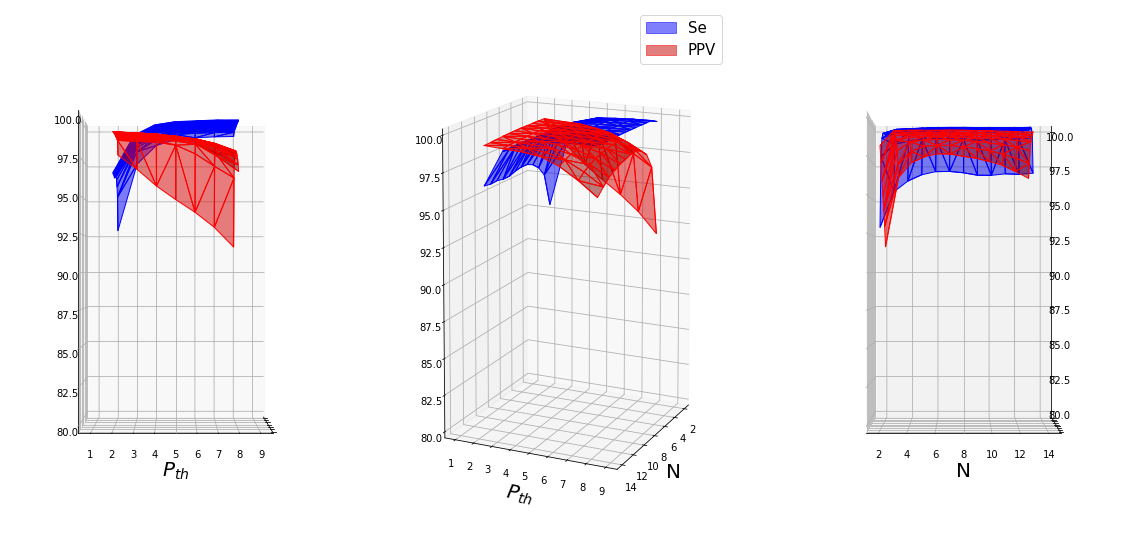

In [93]:
from mpl_toolkits.mplot3d import Axes3D


optimization_matrix = parameter_optimization

# Sensitivity and positive predictivity
optimization_sep = [optimization_matrix['Record'], optimization_matrix['TP']/(optimization_matrix['TP'] + optimization_matrix['FN']), optimization_matrix['TP']/(optimization_matrix['TP'] + optimization_matrix['FP'])]
optimization_sep = pd.DataFrame({'Record':optimization_sep[0],
                                 'Se':optimization_sep[1], 
                                 'PPV':optimization_sep[2],
                                 'N': optimization_matrix['N'],
                                 'Pth': optimization_matrix['Pth'],
                                } )
optimization_sep = se_p
X = optimization_sep['N']
Y = optimization_sep['Pth']
Z1 = optimization_sep['Se_mean']
Z2 = optimization_sep['PPV_mean']


# LEFT PLOT
# Plot X,Y,Z
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(131, projection='3d')
ax.plot_trisurf(X, Y, Z1, color='blue', edgecolors='b', alpha=0.5,label = 'Se')
ax.plot_trisurf(X, Y, Z2, color='red', edgecolors='r', alpha=0.5, label = 'PPV')
ax.set_ylabel('$P_{th}$',fontsize = 20)
ax.view_init(azim=0, elev=0)
ax.set_xticklabels([])
ax.set_zlim(80, 100)


# MID PLOT
ax2 = fig.add_subplot(132, projection='3d')
surf1 = ax2.plot_trisurf(X, Y, Z1, color='blue', edgecolors='b', alpha=0.5,label = 'Se')
surf2 = ax2.plot_trisurf(X, Y, Z2, color='red', edgecolors='r', alpha=0.5, label = 'PPV')
ax2.set_xlabel('N',fontsize = 20)
ax2.set_ylabel('$P_{th}$',fontsize = 20)
ax2.view_init(azim=25, elev=10)

surf1._facecolors2d = surf1._facecolors3d
surf1._edgecolors2d = surf1._edgecolors3d
surf2._facecolors2d = surf1._facecolors3d
surf2._edgecolors2d = surf1._edgecolors3d
ax2.legend(fontsize = 15)
ax2.set_zlim(80, 100)


# RIGHT PLOT
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_trisurf(X, Y, Z1, color='blue', edgecolors='b', alpha=0.5,label = 'Se')
ax3.plot_trisurf(X, Y, Z2, color='red', edgecolors='r', alpha=0.5, label = 'PPV')
ax3.set_xlabel('N',fontsize = 20)
ax3.set_yticklabels([])
ax3.view_init(azim=270, elev=0)
ax3.set_zlim(80, 100)

plt.show()

Left)
- low Pth -> low Se; high PPV  : threshold decreases slowly, missed peaks
- high Pth -> high Se; low PPV : threshold decreases faster, false positives

Middle)
- intersection of the Se and PPV planes

Right)
- low N -> low Se; low PPV : not able to track the QRS changes of the peak
- high N -> no difference for n > 3 ( choose 5 samples at 250 Hz -> 20 ms, representative of the slope)